# Track Machine Learning experiments and models

##### This notebook demonstrates an anomaly detection process on a sales dataset using Spark, Pandas, and Isolation Forest. The steps include:
###### 1. Initializing a Spark session and enabling Arrow optimization for efficient data transfer between Spark and Pandas.
###### 2. Loading the entire sales dataset from the lakehouse into a Spark DataFrame.
###### 3. Converting the Spark DataFrame to a Pandas DataFrame for further processing.
###### 4. Cleaning the 'Sales' column by removing non-numeric characters and converting 'Sales' and 'Profit' columns to numeric types.
###### 5. Dropping rows with NaN values in the 'Sales' and 'Profit' columns.
###### 6. Normalizing the 'Sales' and 'Profit' data using StandardScaler.
###### 7. Initializing and fitting an Isolation Forest model to detect anomalies in the normalized data.
###### 8. Predicting anomalies and classifying data points as normal or anomalous.
###### 9. Visualizing the anomalies using a scatter plot with improved readability and aesthetics.


StatementMeta(, fc726287-6c24-423f-94dd-4e6847908fe0, 20, Finished, Available, Finished)

Number of entries in the table: 5901


Number of anomalies detected: 73


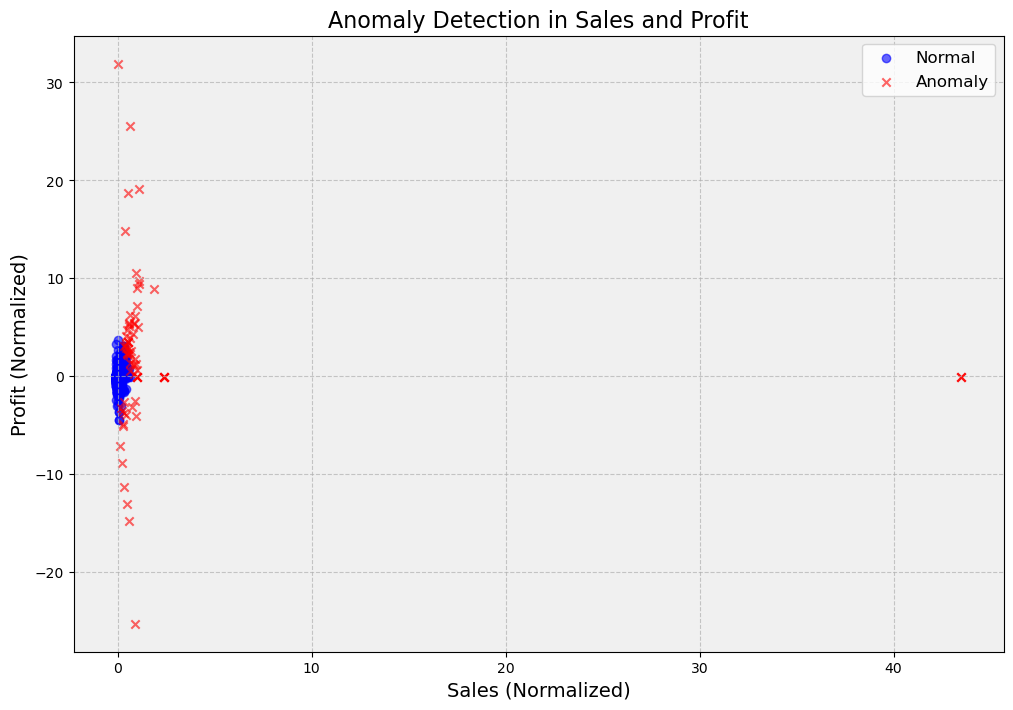

In [10]:
import pandas as pd
import re
from pyspark.sql import SparkSession
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("LakehouseTraining").getOrCreate()

# Enable Arrow optimization
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Load the entire table into a Spark DataFrame
df = spark.sql("SELECT * FROM lakehouseTraining.`superstore sales dataset`")
entry_count = df.count()
print("Number of entries in the table:", entry_count)

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Clean the 'Sales' column by removing non-numeric characters
pandas_df['Sales'] = pandas_df['Sales'].apply(lambda x: re.sub(r'[^0-9.]', '', str(x)))

# Convert 'Sales' and 'Profit' columns to numeric
pandas_df['Sales'] = pd.to_numeric(pandas_df['Sales'], errors='coerce')
pandas_df['Profit'] = pd.to_numeric(pandas_df['Profit'], errors='coerce')

# Drop rows with NaN values
pandas_df.dropna(subset=['Sales', 'Profit'], inplace=True)

# Normalize the data
scaler = StandardScaler()
pandas_df[['Sales', 'Profit']] = scaler.fit_transform(pandas_df[['Sales', 'Profit']])

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.0125, random_state=42)

# Fit the model
iso_forest.fit(pandas_df[['Sales', 'Profit']].values)

# Predict anomalies using the same feature names
pandas_df['anomaly'] = iso_forest.predict(pandas_df[['Sales', 'Profit']].values)

# Define normal and anomaly data points
normals = pandas_df[pandas_df['anomaly'] == 1]
anomalies = pandas_df[pandas_df['anomaly'] == -1]

print("Number of anomalies detected:", len(anomalies))

# Visualize the anomalies with improvements
plt.figure(figsize=(12, 8))
plt.scatter(normals['Sales'], normals['Profit'], c='blue', label='Normal', alpha=0.6, marker='o')
plt.scatter(anomalies['Sales'], anomalies['Profit'], c='red', label='Anomaly', alpha=0.6, marker='x')
plt.xlabel('Sales (Normalized)', fontsize=14)
plt.ylabel('Profit (Normalized)', fontsize=14)
plt.title('Anomaly Detection in Sales and Profit', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f0f0f0')
plt.show()

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

# Assuming pandas_df is already defined and cleaned as in your previous code

# Prepare the data for Prophet
# Prophet requires the dataframe to have columns 'ds' (date) and 'y' (value to forecast)
pandas_df['ds'] = pd.to_datetime(pandas_df['Order_Date'])  # Use 'Order_Date' as the date column
pandas_df['y'] = pandas_df['Sales']  # Use 'Sales' as the column to forecast

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(pandas_df[['ds', 'y']])

# Create a dataframe for future dates
future = model.make_future_dataframe(periods=365)  # Forecast for the next 365 days

# Make predictions
forecast = model.predict(future)

# Convert to numpy array to avoid FutureWarning
forecast['ds'] = np.array(forecast['ds'].dt.to_pydatetime())

# Plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()